# Basic Intro to Gaussian Processes

### By R. Vasudevan
### Center for Nanophase Materials Sciences, Oak Ridge National Laboratory

Here we will go through the basics of Gaussian Processes.

The code below borrow heavily from http://katbailey.github.io/post/gaussian-processes-for-dummies/

This is a large topic and there are a lot of good resources available online:

A very nice visual and interactive demonstration:
https://distill.pub/2019/visual-exploration-gaussian-processes/

Another one:
https://thegradient.pub/gaussian-process-not-quite-for-dummies/

Youtube lectures:
https://www.youtube.com/watch?v=xBE8qdAAj3w

And an in-depth one:
https://www.youtube.com/watch?v=MfHKW5z-OOA



In [6]:
# Load packages necessary
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix as dist_matrix

# Samples from Gaussian Process

First, we will start by understanding what a Gaussian Process is. As explained in the presentation, the idea is that we draw samples from the process, and each of the samples is itslef a function:

$f \sim GP(m(x), k(x,x'))$

We can observe how these functions behave for different kernels and their differnet hyperparameters. Not that this is a PRIOR, i.e. before we have seen any data. Once data is available, we can then generate a posterior over functions. The advantage of GPs are that they are highly flexible models with infinite numbers of parameters, and provide uncertainty quantification. The latter is most critical for the use of GPs in Bayesian Optimization, which we will explore in subsequent notebooks. 

Text(0.5, 0, 'Y')

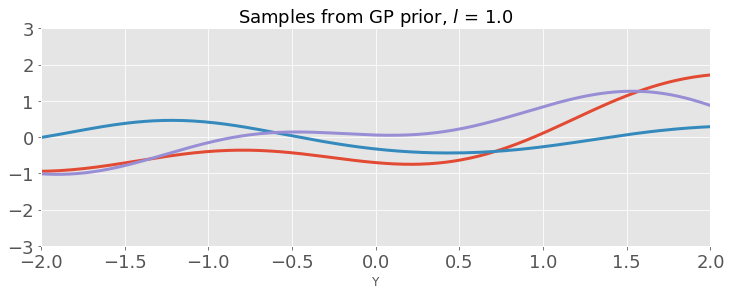

In [7]:
# Test data
n = 280
Xtest = np.linspace(-2, 2, n).reshape(-1,1)

# Define the kernel function: in this case a squared exponential or 'RBF' kernel
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 1.0
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-8*np.eye(n))

# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3))) #This will generate the samples from the process!

# Now let's plot the sampled functions.
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (12,4))
plt.plot(Xtest, f_prior, linewidth = 3)
plt.axis([-2, 2, -3, 3])
plt.title('Samples from GP prior, $l$ = {}'.format(param), fontsize = 18)
plt.setp(axes.get_xticklabels(), fontsize=18);
plt.setp(axes.get_yticklabels(), fontsize=18);
plt.xlabel('X')
plt.xlabel('Y')

In [8]:
# Play with a different kernel
# Define the kernel function: in this case a squared exponential or 'RBF' kernel
def matern_kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    g = 1+np.sqrt(3*sqdist)/param
    h = np.exp(-(np.sqrt(3*sqdist))/param)
    return g*h


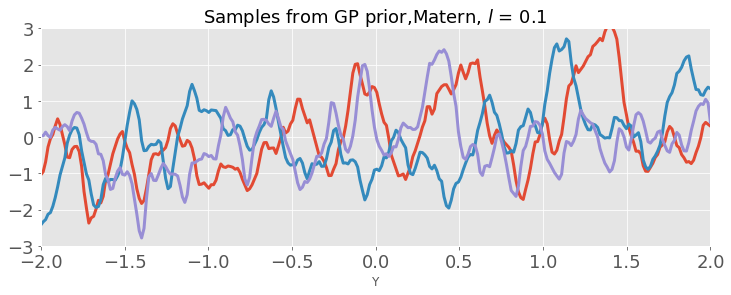

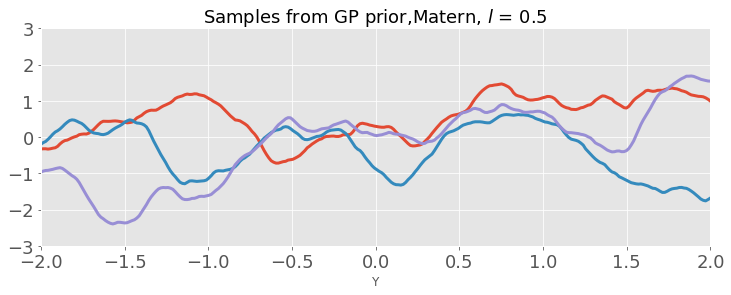

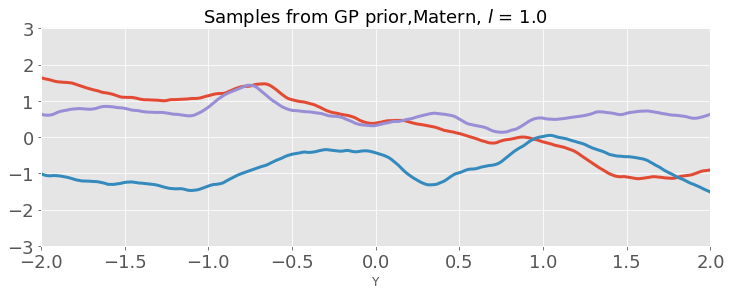

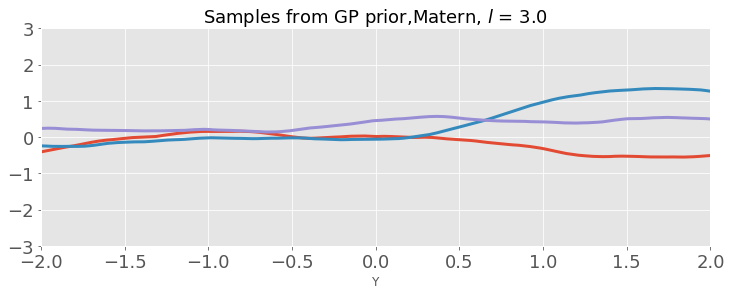

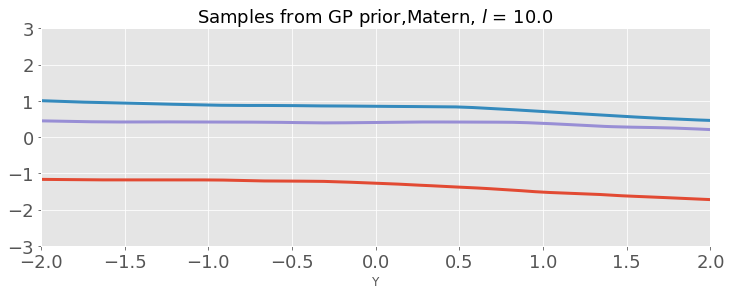

In [11]:
#Plot the samples for different values of kernel lengthscale, for Matern Kernel this time.
for param in [0.1, 0.5, 1.0, 3.0, 10.0]:

    K_ss = matern_kernel(Xtest, Xtest, param)

    # Get cholesky decomposition (square root) of the
    # covariance matrix
    L = np.linalg.cholesky(K_ss + 1e-8*np.eye(n))

    # Sample 3 sets of standard normals for our test points,
    # multiply them by the square root of the covariance matrix
    f_prior = np.dot(L, np.random.normal(size=(n,3))) #This will generate the samples from the process!

    # Now let's plot the sampled functions.
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (12,4))
    plt.plot(Xtest, f_prior, linewidth = 3)
    plt.axis([-2, 2, -3, 3])
    plt.title('Samples from GP prior,Matern, $l$ = {}'.format(param), fontsize = 18)
    plt.setp(axes.get_xticklabels(), fontsize=18);
    plt.setp(axes.get_yticklabels(), fontsize=18);
    plt.xlabel('X')
    plt.xlabel('Y')

# Obtaining the posterior

Now we can try to play with simulated data and obtain the posterior over the functions, to obtain mean and standard deviation of predictions...for this we will use scikit-learn.

Text(0, 0.5, 'f(x)')

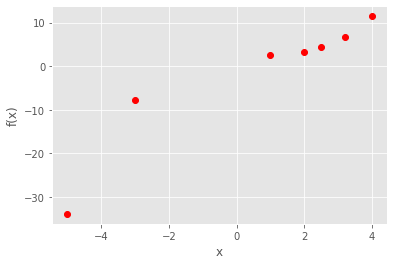

In [96]:
# Create a simulated dataset with a polynomial function
X = np.array([-5,-3,1,2,2.5,3.2,4.0]).reshape(-1,1) #training points
y = np.polyval([0.2,-.34,0.50,2.1], X).ravel() #function values at these points

plt.figure()
plt.plot(X, y, 'ro')
plt.xlabel('x')
plt.ylabel('f(x)')

Text(0.5, 1.0, 'Kernel = RBF(length_scale=0.985)')

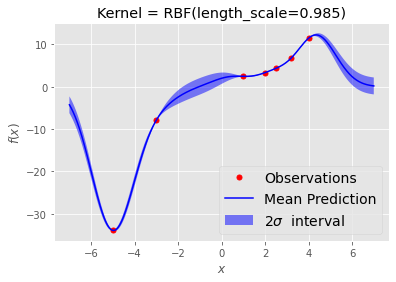

In [98]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

x = np.atleast_2d(np.linspace(-7, 7, 1000)).T

# Instantiate a Gaussian Process model
#Start with the kernel

kernel = RBF(10.0, (1e-4, 1e4)) #kernel has lengthscale 10, and has lengthscale bounds
#the lengthscale will be found during the training (maximum likelihood estimation)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Find the mean and standard deviation
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 2sigma interval

plt.figure()
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Mean Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 2 * sigma,
                        (y_pred + 2 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='2$\sigma$  interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='lower right', fontsize = 14)
plt.title('Kernel = {}'.format(gp.kernel_))

Text(0, 0.5, 'f(x)')

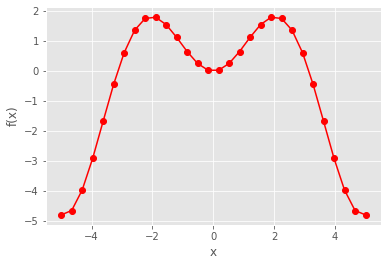

In [87]:
#Let's try with another function
# Create a simulated dataset with a polynomial function
X = np.linspace(-5,5,30).reshape(-1,1) #training points
y = (np.sin(X)*X).ravel() #function values at these points

plt.figure()
plt.plot(X, y, 'ro-')
plt.xlabel('x')
plt.ylabel('f(x)')


Text(0.5, 1.0, 'Kernel = Matern(length_scale=1.21, nu=1.5)')

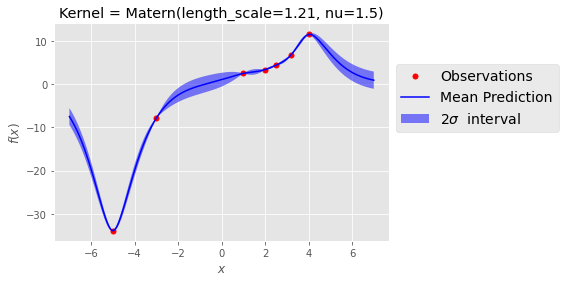

In [100]:
x = np.atleast_2d(np.linspace(-7, 7, 1000)).T

#Let's use a Matern Kernel 
kernel = Matern(1.0, (0.3, 5.0)) #kernel has lengthscale 10, and has lengthscale bounds
#the lengthscale will be found during the training (maximum likelihood estimation)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=500)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Find the mean and standard deviation
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 2sigma interval
plt.figure()
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Mean Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 2 * sigma,
                        (y_pred + 2 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='2$\sigma$  interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc=[1.02, 0.5], fontsize = 14)
plt.title('Kernel = {}'.format(gp.kernel_))

# Exercise

To test your knowledge, do the following exercise

1. Simulate some other kind of  data. E.g., use more complicated functions
2. Test how the GP prediction behaves with different kernels
3. If you have noisy data with some given errors, you can pass these to the regressor (alpha=) parameter. See how different noise level affects the GP predictions.